In [1]:
import uproot
import awkward as ak 
import vector
vector.register_awkward()
import matplotlib.pyplot as plt

In [9]:
filename = "h2h2lPlM/h2h2lPlM_BP5_lam345_1/Events/run_01/unweighted_events.root:LHEF;1"
with uproot.open(filename) as f:
    weights = ak.flatten(f['Event']['Event.Weight'].arrays()["Event.Weight"])
    tree = f['Particle']
    events = tree.arrays(library="ak", how="zip")

In [13]:
print(weights)
print(sum(weights))

[0.0123, 0.0123, 0.0123, 0.0123, 0.0123, ..., 0.0123, 0.0123, 0.0123, 0.0123]
246.5491399999635


dict_keys(['5_-1', '5_0', '5_1', '5_2'])


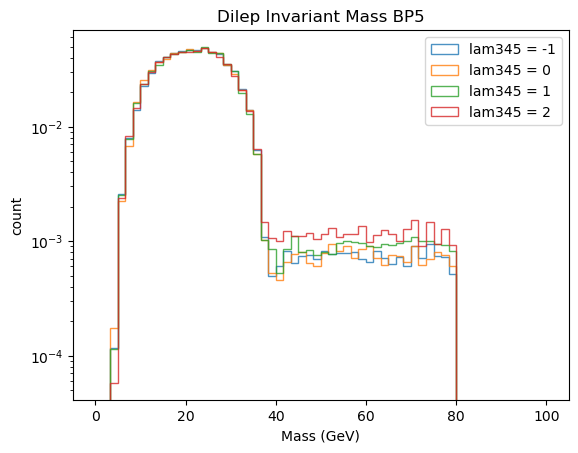

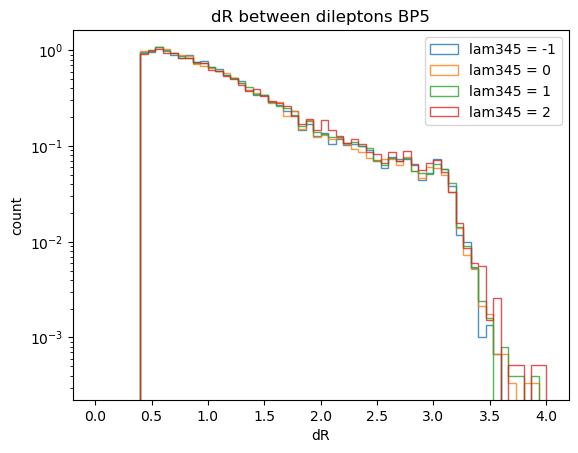

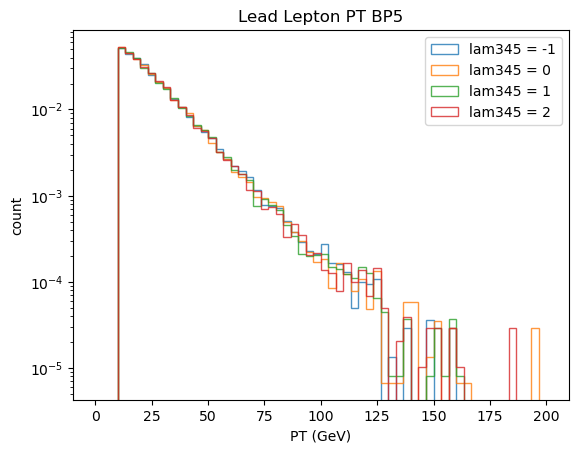

In [2]:
#BPs = [2, 5, 6]
BPs = [5]
lams = [-1, 0, 1, 2]

def getVars(lep, weights):
    vars = {}
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    cut = lep1['PID'] == -lep2['PID']
    mass = dilep.mass
    mass_cut = mass < 80
    cut = cut & mass_cut
    lep = lep[cut]
    weights = weights[cut]
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    mass = dilep.mass
    vars['mass'] = mass
    dR = lep1.deltaR(lep2)
    vars['dR'] = dR
    leadpt = lep1.pt
    vars['leadpt'] = leadpt
    return vars, weights
    
plot_settings = {
    "mass" : {
        "min" : 0,
        "max" : 100,
        "title" : "Dilep Invariant Mass",
        "x" : "Mass (GeV)"
    },
    "dR" : {
        "min" : 0,
        "max" : 4,
        "title" : "dR between dileptons",
        "x" : "dR"
    },
    "leadpt" : {
        "min" : 0,
        "max" : 200,
        "title" : "Lead Lepton PT",
        "x" : "PT (GeV)"
    }
}

variables = {}

for BP in BPs:
    for lam in lams:
        #filename = f"h2h2lPlMnunu_BP{BP}_lam345_{lam}/Events/run_01/unweighted_events.root:LHEF;1"
        events_array = []
        weights_array = []
        for filename in [f"h2h2lPlMnunu/h2h2lPlMnunu_BP{BP}_lam345_{lam}", f"h2h2lPlM/h2h2lPlM_BP{BP}_lam345_{lam}"]:
            filename = filename + "/Events/run_01/unweighted_events.root:LHEF;1"
            with uproot.open(filename) as f:
                weights = f['Event']['Event.Weight'].arrays()
                tree = f['Particle']
                events = tree.arrays(library="ak", how="zip")
                part = events.Particle
                # Only want final state particles 
                part = part[part['Status'] == 1]
                # Only want the leptons
                lep = part[(abs(part.PID) == 11) | (abs(part.PID) == 13)]
                branches = ['Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity']
                for b in branches:
                    lep[b.lower()] = lep[b]
                # Change to 4V
                events_array.append(lep)
                weights_array.append(weights)
        weights = ak.concatenate(weights_array, axis=0)
        lep = ak.concatenate(events_array, axis=0) 
        lep = ak.Array(lep, with_name="Momentum4D")
        
        vars, weights = getVars(lep, weights)
        variables[f"{BP}_{lam}"] = [vars, ak.flatten(weights['Event.Weight'])]

print(variables.keys())
# Now plot all of them
var_names = ['mass', 'dR', 'leadpt']
for var in var_names:
    settings = plot_settings[var]
    for BP in BPs:
        plt.clf()
        for lam in lams:
            _ = plt.hist(variables[f"{BP}_{lam}"][0][var], bins=60, histtype='step', density=True, alpha=0.8, range=(settings['min'], settings['max']), label=f"lam345 = {lam}", weights=variables[f"{BP}_{lam}"][1])
        plt.title(f"{settings['title']} BP{BP}")
        plt.yscale('log')
        plt.xlabel(settings['x'])
        plt.ylabel("count")
        plt.legend()
        plt.show()

        

In [5]:
print(ak.fields(events.Particle))
part = events.Particle
branches = ['Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity']
for b in branches:
    lep[b.lower()] = lep[b]

['fUniqueID', 'fBits', 'PID', 'Status', 'Mother1', 'Mother2', 'ColorLine1', 'ColorLine2', 'Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity', 'LifeTime', 'Spin']


dict_keys(['5_2'])


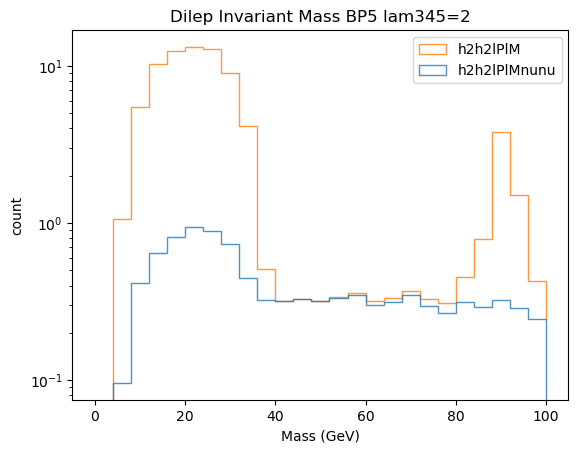

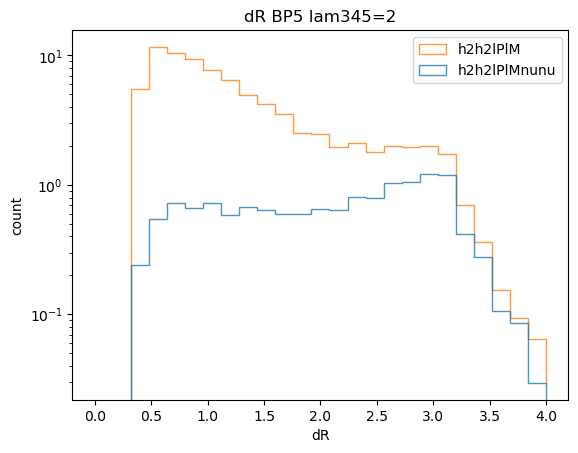

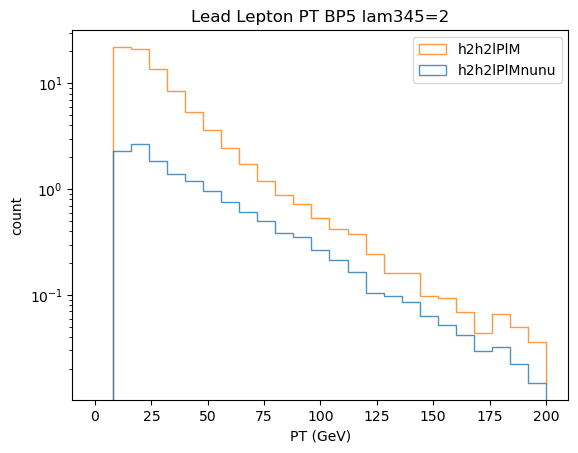

In [7]:
# BPs = [2, 5, 6]
BPs = [5]
lams = [2]

def getEventVariables(lep, weights):
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    cut = lep1['PID'] == -lep2['PID']
    mass = dilep.mass
    # mass_cut = mass < 80
    # cut = cut & mass_cut
    lep = lep[cut]
    weights = weights[cut]
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    mass = dilep.mass
    dR = lep1.deltaR(lep2)
    leadpt = lep1.pt
    return mass, dR, leadpt, weights

def getVars(leps, weights):
    vars = {"mass" : [], "dR" : [], "leadpt" : []}
    new_weights = []
    for lep, weight in zip(leps, weights):
        mass, dR, leadpt, wei = getEventVariables(lep, weight)
        vars['mass'].append(mass)
        vars['dR'].append(dR)
        vars['leadpt'].append(leadpt)
        wei = ak.flatten(wei['Event.Weight'])
        new_weights.append(wei)
    
    return vars, new_weights
    
plot_settings = {
    "mass" : {
        "min" : 0,
        "max" : 100,
        "title" : "Dilep Invariant Mass",
        "x" : "Mass (GeV)"
    },
    "dR" : {
        "min" : 0,
        "max" : 4,
        "title" : "dR",
        "x" : "dR"
    },
    "leadpt" : {
        "min" : 0,
        "max" : 200,
        "title" : "Lead Lepton PT",
        "x" : "PT (GeV)"
    }
}

variables = {}

for BP in BPs:
    for lam in lams:
        #filename = f"h2h2lPlMnunu_BP{BP}_lam345_{lam}/Events/run_01/unweighted_events.root:LHEF;1"
        events_array = []
        weights_array = []
        for filename in [f"h2h2lPlMnunu/h2h2lPlMnunu_BP{BP}_lam345_{lam}", f"h2h2lPlM/h2h2lPlM_BP{BP}_lam345_{lam}"]:
            filename = filename + "/Events/run_01/unweighted_events.root:LHEF;1"
            with uproot.open(filename) as f:
                weights = f['Event']['Event.Weight'].arrays()
                tree = f['Particle']
                events = tree.arrays(library="ak", how="zip")
                part = events.Particle
                # Only want final state particles 
                part = part[part['Status'] == 1]
                # Only want the leptons
                lep = part[(abs(part.PID) == 11) | (abs(part.PID) == 13)]
                branches = ['Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity']
                for b in branches:
                    lep[b.lower()] = lep[b]
                # Change to 4V
                events_array.append(lep)
                weights_array.append(weights)
        
        lep = [ak.Array(ev, with_name="Momentum4D") for ev in events_array]
        
        vars, weights = getVars(lep, weights_array)
        # weights[0] = weights[0] * 0.25
        # weights[1] = weights[1] * 0.50
        variables[f"{BP}_{lam}"] = [vars, weights]

labels = ['h2h2lPlMnunu', "h2h2lPlM"]

print(variables.keys())
# Now plot all of them
var_names = ['mass', 'dR', 'leadpt']
for var in var_names:
    settings = plot_settings[var]
    for BP in BPs:
        plt.clf()
        for lam in lams:
            _ = plt.hist(variables[f"{BP}_{lam}"][0][var], bins=25, histtype='step', alpha=0.8, range=(settings['min'], settings['max']), label=labels, weights=variables[f"{BP}_{lam}"][1], stacked=True)
        plt.title(f"{settings['title']} BP{BP} lam345={lam}")
        plt.legend()
        plt.yscale('log')
        plt.xlabel(settings['x'])
        plt.ylabel("count")
        plt.legend()
        plt.show()

        

dict_keys(['5_1', '5_2'])


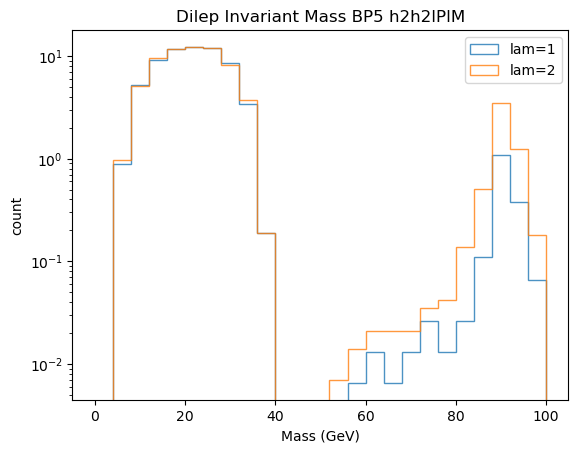

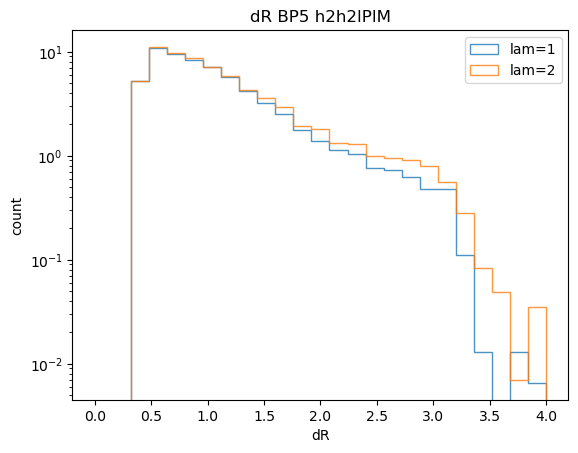

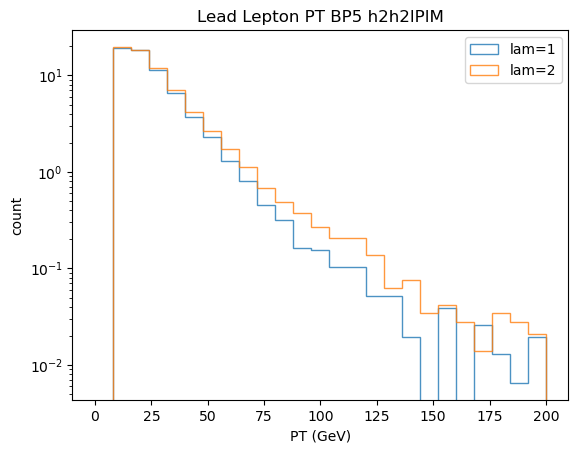

In [14]:
# BPs = [2, 5, 6]
BPs = [5]
lams = [1, 2]

def getEventVariables(lep, weights):
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    cut = lep1['PID'] == -lep2['PID']
    mass = dilep.mass
    # mass_cut = mass < 80
    # cut = cut & mass_cut
    lep = lep[cut]
    weights = weights[cut]
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    mass = dilep.mass
    dR = lep1.deltaR(lep2)
    leadpt = lep1.pt
    return mass, dR, leadpt, weights

def getVars(leps, weights):
    vars = {"mass" : [], "dR" : [], "leadpt" : []}
    new_weights = []
    for lep, weight in zip(leps, weights):
        mass, dR, leadpt, wei = getEventVariables(lep, weight)
        vars['mass'].append(mass)
        vars['dR'].append(dR)
        vars['leadpt'].append(leadpt)
        wei = ak.flatten(wei['Event.Weight'])
        new_weights.append(wei)
    
    return vars, new_weights
    
plot_settings = {
    "mass" : {
        "min" : 0,
        "max" : 100,
        "title" : "Dilep Invariant Mass",
        "x" : "Mass (GeV)"
    },
    "dR" : {
        "min" : 0,
        "max" : 4,
        "title" : "dR",
        "x" : "dR"
    },
    "leadpt" : {
        "min" : 0,
        "max" : 200,
        "title" : "Lead Lepton PT",
        "x" : "PT (GeV)"
    }
}

variables = {}

for BP in BPs:
    for lam in lams:
        #filename = f"h2h2lPlMnunu_BP{BP}_lam345_{lam}/Events/run_01/unweighted_events.root:LHEF;1"
        events_array = []
        weights_array = []
        for filename in [f"h2h2lPlM/h2h2lPlM_BP{BP}_lam345_{lam}"]:
            filename = filename + "/Events/run_01/unweighted_events.root:LHEF;1"
            with uproot.open(filename) as f:
                weights = f['Event']['Event.Weight'].arrays()
                tree = f['Particle']
                events = tree.arrays(library="ak", how="zip")
                part = events.Particle
                # Only want final state particles 
                part = part[part['Status'] == 1]
                # Only want the leptons
                lep = part[(abs(part.PID) == 11) | (abs(part.PID) == 13)]
                branches = ['Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity']
                for b in branches:
                    lep[b.lower()] = lep[b]
                # Change to 4V
                events_array.append(lep)
                weights_array.append(weights)
        
        lep = [ak.Array(ev, with_name="Momentum4D") for ev in events_array]
        
        vars, weights = getVars(lep, weights_array)
        # weights[0] = weights[0] * 0.25
        # weights[1] = weights[1] * 0.50
        variables[f"{BP}_{lam}"] = [vars, weights]

#labels = ['', "h2h2lPlM"]

print(variables.keys())
# Now plot all of them
var_names = ['mass', 'dR', 'leadpt']
for var in var_names:
    settings = plot_settings[var]
    for BP in BPs:
        plt.clf()
        for lam in lams:
            _ = plt.hist(variables[f"{BP}_{lam}"][0][var], bins=25, histtype='step', alpha=0.8, range=(settings['min'], settings['max']), label=f"lam={lam}", weights=variables[f"{BP}_{lam}"][1], stacked=True)
        plt.title(f"{settings['title']} BP{BP} h2h2lPlM")
        plt.legend()
        plt.yscale('log')
        plt.xlabel(settings['x'])
        plt.ylabel("count")
        plt.legend()
        plt.show()

        

dict_keys(['5_1', '5_2'])


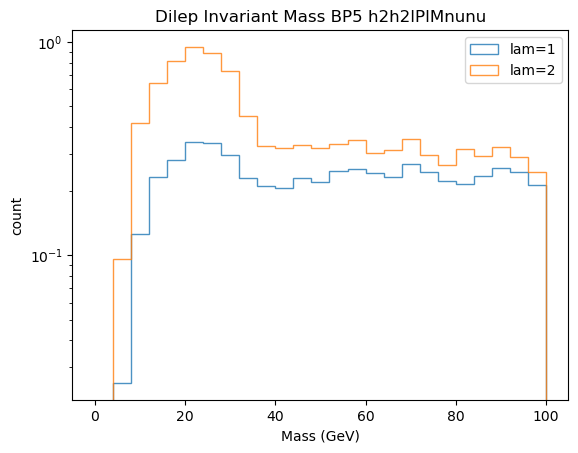

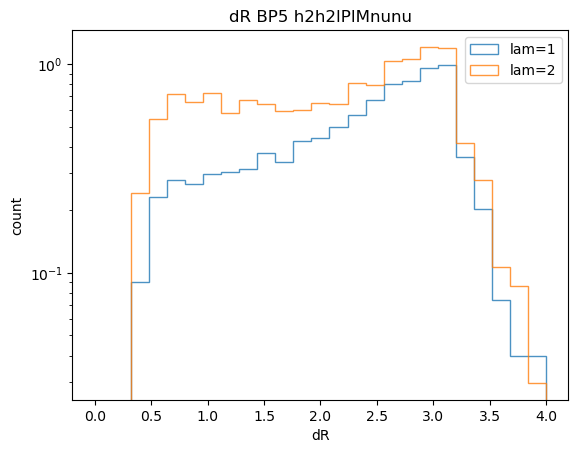

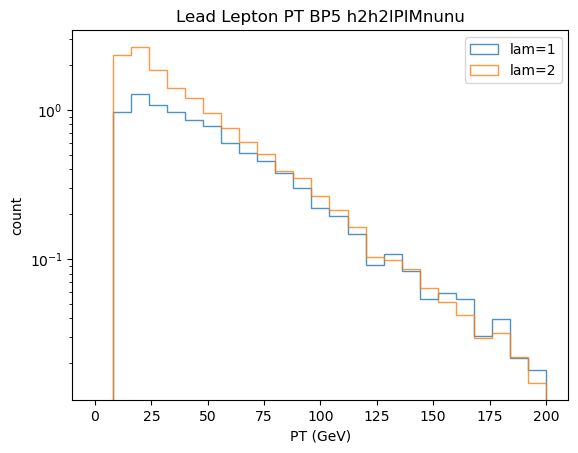

In [16]:
# BPs = [2, 5, 6]
BPs = [5]
lams = [1, 2]

def getEventVariables(lep, weights):
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    cut = lep1['PID'] == -lep2['PID']
    mass = dilep.mass
    # mass_cut = mass < 80
    # cut = cut & mass_cut
    lep = lep[cut]
    weights = weights[cut]
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    mass = dilep.mass
    dR = lep1.deltaR(lep2)
    leadpt = lep1.pt
    return mass, dR, leadpt, weights

def getVars(leps, weights):
    vars = {"mass" : [], "dR" : [], "leadpt" : []}
    new_weights = []
    for lep, weight in zip(leps, weights):
        mass, dR, leadpt, wei = getEventVariables(lep, weight)
        vars['mass'].append(mass)
        vars['dR'].append(dR)
        vars['leadpt'].append(leadpt)
        wei = ak.flatten(wei['Event.Weight'])
        new_weights.append(wei)
    
    return vars, new_weights
    
plot_settings = {
    "mass" : {
        "min" : 0,
        "max" : 100,
        "title" : "Dilep Invariant Mass",
        "x" : "Mass (GeV)"
    },
    "dR" : {
        "min" : 0,
        "max" : 4,
        "title" : "dR",
        "x" : "dR"
    },
    "leadpt" : {
        "min" : 0,
        "max" : 200,
        "title" : "Lead Lepton PT",
        "x" : "PT (GeV)"
    }
}

variables = {}

for BP in BPs:
    for lam in lams:
        #filename = f"h2h2lPlMnunu_BP{BP}_lam345_{lam}/Events/run_01/unweighted_events.root:LHEF;1"
        events_array = []
        weights_array = []
        for filename in [f"h2h2lPlMnunu/h2h2lPlMnunu_BP{BP}_lam345_{lam}"]:
            filename = filename + "/Events/run_01/unweighted_events.root:LHEF;1"
            with uproot.open(filename) as f:
                weights = f['Event']['Event.Weight'].arrays()
                tree = f['Particle']
                events = tree.arrays(library="ak", how="zip")
                part = events.Particle
                # Only want final state particles 
                part = part[part['Status'] == 1]
                # Only want the leptons
                lep = part[(abs(part.PID) == 11) | (abs(part.PID) == 13)]
                branches = ['Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity']
                for b in branches:
                    lep[b.lower()] = lep[b]
                # Change to 4V
                events_array.append(lep)
                weights_array.append(weights)
        
        lep = [ak.Array(ev, with_name="Momentum4D") for ev in events_array]
        
        vars, weights = getVars(lep, weights_array)
        # weights[0] = weights[0] * 0.25
        # weights[1] = weights[1] * 0.50
        variables[f"{BP}_{lam}"] = [vars, weights]

#labels = ['', "h2h2lPlM"]

print(variables.keys())
# Now plot all of them
var_names = ['mass', 'dR', 'leadpt']
for var in var_names:
    settings = plot_settings[var]
    for BP in BPs:
        plt.clf()
        for lam in lams:
            _ = plt.hist(variables[f"{BP}_{lam}"][0][var], bins=25, histtype='step', alpha=0.8, range=(settings['min'], settings['max']), label=f"lam={lam}", weights=variables[f"{BP}_{lam}"][1], stacked=True)
        plt.title(f"{settings['title']} BP{BP} h2h2lPlMnunu")
        plt.legend()
        plt.yscale('log')
        plt.xlabel(settings['x'])
        plt.ylabel("count")
        plt.legend()
        plt.show()

        

dict_keys(['2_2', '5_2', '6_2'])


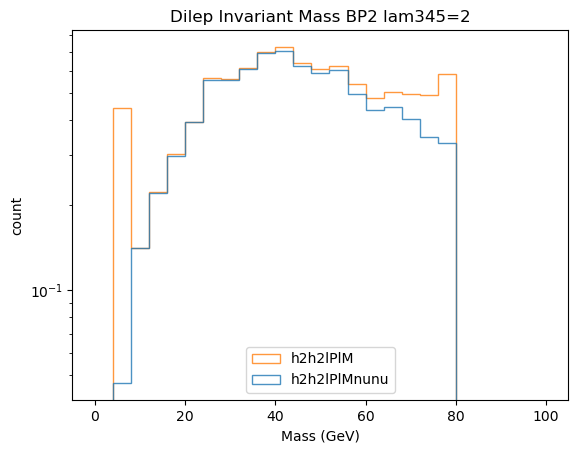

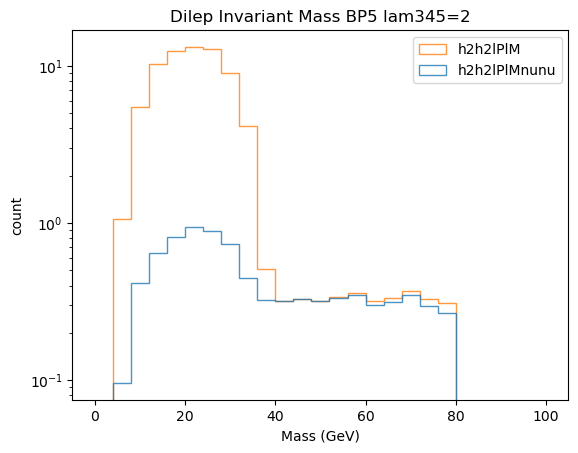

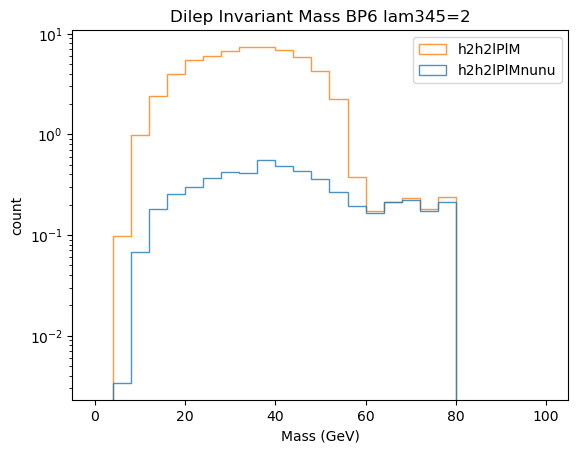

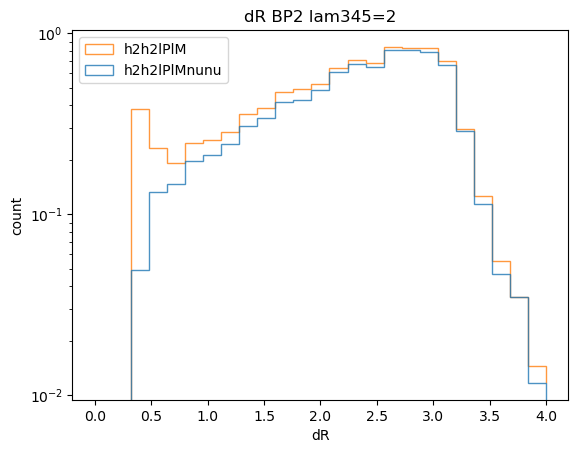

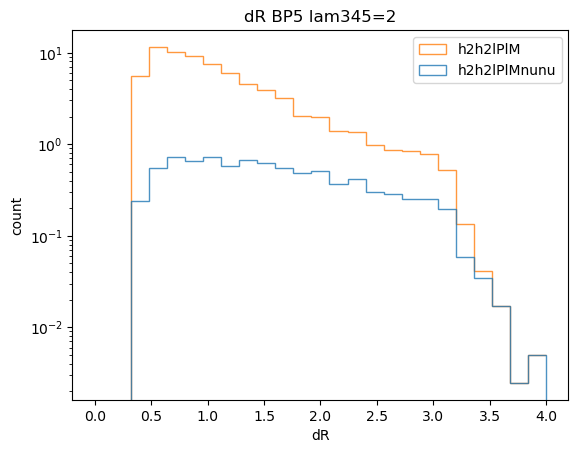

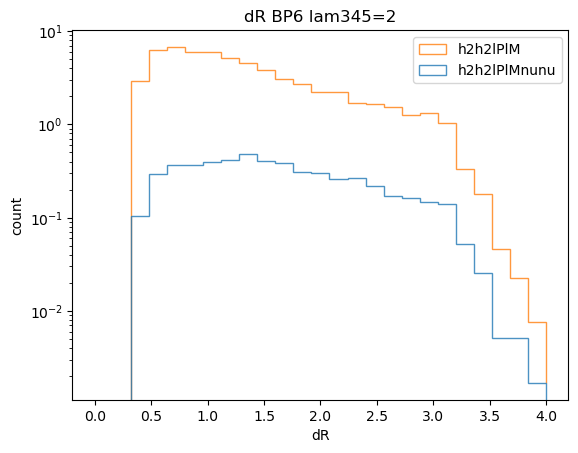

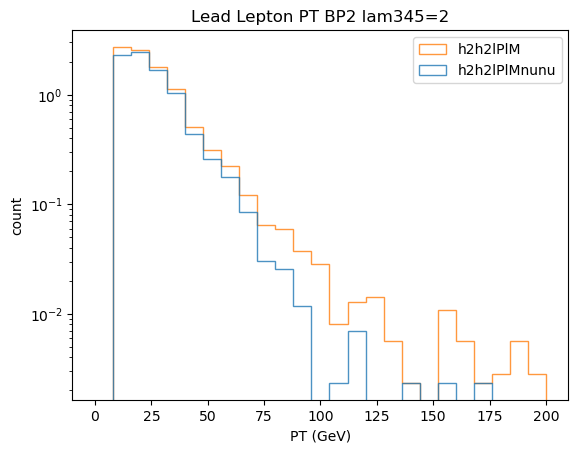

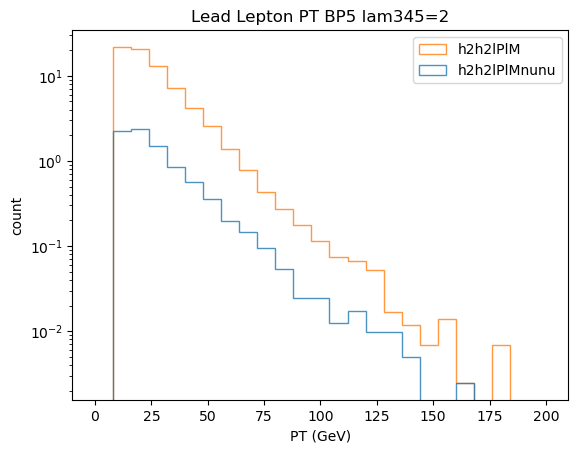

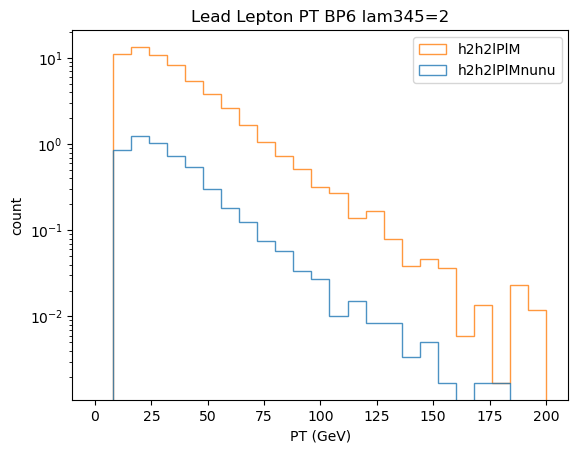

In [26]:
BPs = [2, 5, 6]
lams = [2]

def getEventVariables(lep, weights):
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    cut = lep1['PID'] == -lep2['PID']
    mass = dilep.mass
    mass_cut = mass < 80
    cut = cut & mass_cut
    lep = lep[cut]
    weights = weights[cut]
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    mass = dilep.mass
    dR = lep1.deltaR(lep2)
    leadpt = lep1.pt
    return mass, dR, leadpt, weights

def getVars(leps, weights):
    vars = {"mass" : [], "dR" : [], "leadpt" : []}
    new_weights = []
    for lep, weight in zip(leps, weights):
        mass, dR, leadpt, wei = getEventVariables(lep, weight)
        vars['mass'].append(mass)
        vars['dR'].append(dR)
        vars['leadpt'].append(leadpt)
        wei = ak.flatten(wei['Event.Weight'])
        new_weights.append(wei)
    
    return vars, new_weights
    
plot_settings = {
    "mass" : {
        "min" : 0,
        "max" : 100,
        "title" : "Dilep Invariant Mass",
        "x" : "Mass (GeV)"
    },
    "dR" : {
        "min" : 0,
        "max" : 4,
        "title" : "dR",
        "x" : "dR"
    },
    "leadpt" : {
        "min" : 0,
        "max" : 200,
        "title" : "Lead Lepton PT",
        "x" : "PT (GeV)"
    }
}

variables = {}

for BP in BPs:
    for lam in lams:
        #filename = f"h2h2lPlMnunu_BP{BP}_lam345_{lam}/Events/run_01/unweighted_events.root:LHEF;1"
        events_array = []
        weights_array = []
        for filename in [f"h2h2lPlMnunu/h2h2lPlMnunu_BP{BP}_lam345_{lam}", f"h2h2lPlM/h2h2lPlM_BP{BP}_lam345_{lam}"]:
            filename = filename + "/Events/run_01/unweighted_events.root:LHEF;1"
            with uproot.open(filename) as f:
                weights = f['Event']['Event.Weight'].arrays()
                tree = f['Particle']
                events = tree.arrays(library="ak", how="zip")
                part = events.Particle
                # Only want final state particles 
                part = part[part['Status'] == 1]
                # Only want the leptons
                lep = part[(abs(part.PID) == 11) | (abs(part.PID) == 13)]
                branches = ['Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity']
                for b in branches:
                    lep[b.lower()] = lep[b]
                # Change to 4V
                events_array.append(lep)
                weights_array.append(weights)
        
        lep = [ak.Array(ev, with_name="Momentum4D") for ev in events_array]
        
        vars, weights = getVars(lep, weights_array)
        variables[f"{BP}_{lam}"] = [vars, weights]

labels = ['h2h2lPlMnunu', "h2h2lPlM"]

print(variables.keys())
# Now plot all of them
var_names = ['mass', 'dR', 'leadpt']
for var in var_names:
    settings = plot_settings[var]
    for BP in BPs:
        plt.clf()
        for lam in lams:
            _ = plt.hist(variables[f"{BP}_{lam}"][0][var], bins=25, histtype='step', alpha=0.8, range=(settings['min'], settings['max']), label=labels, weights=variables[f"{BP}_{lam}"][1], stacked=True)
        plt.title(f"{settings['title']} BP{BP} lam345={lam}")
        plt.legend()
        plt.yscale('log')
        plt.xlabel(settings['x'])
        plt.ylabel("count")
        plt.legend()
        plt.show()

        

In [ ]:
BPs = [2, 5, 6]
lams = [-1, 0, 1, 2]

def getVars(lep, weights):
    vars = {}
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    mass = dilep.mass
    mass_cut = mass < 80
    lep = lep[mass_cut]
    weights = weights[mass_cut]
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    mass = dilep.mass
    vars['mass'] = mass
    dR = lep1.deltaR(lep2)
    vars['dR'] = dR
    leadpt = lep1.pt
    vars['leadpt'] = leadpt
    return vars, weights
    
plot_settings = {
    "mass" : {
        "min" : 0,
        "max" : 100,
        "title" : "Dilep Invariant Mass",
        "x" : "Mass (GeV)"
    },
    "dR" : {
        "min" : 0,
        "max" : 4,
        "title" : "dR",
        "x" : "dR"
    },
    "leadpt" : {
        "min" : 0,
        "max" : 200,
        "title" : "Lead Lepton PT",
        "x" : "PT (GeV)"
    }
}

variables = {}

for BP in BPs:
    for lam in lams:
        filename = f"h2h2lPlMnunu_BP{BP}_lam345_{lam}/Events/run_01/unweighted_events.root:LHEF;1"
        with uproot.open(filename) as f:
            weights = f['Event']['Event.Weight'].arrays()
            tree = f['Particle']
            events = tree.arrays(library="ak", how="zip")
            part = events.Particle
            # Only want final state particles 
            part = part[part['Status'] == 1]
            # Only want the leptons
            lep = part[(abs(part.PID) == 11) | (abs(part.PID) == 13)]
            branches = ['Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity']
            for b in branches:
                lep[b.lower()] = lep[b]
            # Change to 4V
            lep = ak.Array(lep, with_name="Momentum4D")
            
            vars, weights = getVars(lep, weights)
            variables[f"{BP}_{lam}"] = [vars, ak.flatten(weights['Event.Weight'])]

print(variables.keys())
# Now plot all of them
var_names = ['mass', 'dR', 'leadpt']
for var in var_names:
    settings = plot_settings[var]
    for BP in BPs:
        plt.clf()
        for lam in lams:
            _ = plt.hist(variables[f"{BP}_{lam}"][0][var], bins=35, histtype='step', density=True, alpha=0.8, range=(settings['min'], settings['max']), label=f"lam345 = {lam}")
        plt.title(f"{settings['title']} BP{BP}")
        #plt.yscale('log')
        plt.xlabel(settings['x'])
        plt.ylabel("count")
        plt.legend()
        plt.show()
        break
    break
        

In [ ]:
with uproot.open("/vols/cms/emc21/idmStudy/BPs/MG5_aMC_v2_6_7/TESTlPlM_BP12/Events/run_01/unweighted_events.root:LHEF;1") as f:
    tree = f['Particle']
    events = tree.arrays(library="ak", how="zip")
    part = events.Particle
    # Only want final state particles 
    part = part[part['Status'] == 1]
    # Only want the leptons
    lep = part[(abs(part.PID) == 11) | (abs(part.PID) == 13)]
    branches = ['Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity']
    for b in branches:
        lep[b.lower()] = lep[b]
    # Change to 4V
    lep = ak.Array(lep, with_name="Momentum4D")


In [ ]:
with uproot.open("/vols/cms/emc21/idmStudy/BPs/MG5_aMC_v2_6_7/TESTlPlM_BP12/Events/run_01/unweighted_events.root:LHEF;1") as f:
    tree = f['Event']
    print(tree.keys())
    weight = tree["Event.Weight"]
    weight = weight.arrays()
    print(weight["Event.Weight"])

In [ ]:
branches = ['Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity']
for b in branches:
    lep[b.lower()] = lep[b]

In [ ]:
print(ak.fields(lep))

In [ ]:
print(lep.PT)
lep1 = lep[:,0]
lep2 = lep[:,1]
dilep = lep1 + lep2
print(dilep.mass)

In [ ]:
lam345s = {"4" : 0.00298, "5" : -0.00298, "6" : 0, "7" : 1}

def getVars(lep):
    vars = {}
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    mass = dilep.mass
    vars['mass'] = mass
    dR = lep1.deltaR(lep2)
    vars['dR'] = dR
    leadpt = lep1.pt
    vars['leadpt'] = leadpt
    return vars
    
plot_settings = {
    "mass" : {
        "min" : 0,
        "max" : 100,
        "title" : "Dilep Invariant Mass",
        "x" : "Mass (GeV)"
    },
    "dR" : {
        "min" : 0,
        "max" : 4,
        "title" : "dR",
        "x" : "dR"
    },
    "leadpt" : {
        "min" : 0,
        "max" : 200,
        "title" : "Lead Lepton PT",
        "x" : "PT (GeV)"
    }
}


variables = {}
for i in range(4, 8):
    filename = f"/vols/cms/emc21/idmStudy/BPs/MG5_aMC_v2_6_7/TESTlPlM_BP12/Events/run_0{i}/unweighted_events.root:LHEF;1"
    with uproot.open(filename) as f:
        tree = f['Particle']
        events = tree.arrays(library="ak", how="zip")
        part = events.Particle
        # Only want final state particles 
        part = part[part['Status'] == 1]
        # Only want the leptons
        lep = part[(abs(part.PID) == 11) | (abs(part.PID) == 13)]
        branches = ['Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity']
        for b in branches:
            lep[b.lower()] = lep[b]
        # Change to 4V
        lep = ak.Array(lep, with_name="Momentum4D")
        
        vars = getVars(lep)
        variables[f'{i}'] = vars

print(variables.keys())
# Now plot all of them
var_names = ['mass', 'dR', 'leadpt']
for var in var_names:
    settings = plot_settings[var]
    for i in range(4, 8):
        _ = plt.hist(variables[f"{i}"][var], bins=35, histtype='step', density=True, alpha=0.8, range=(settings['min'], settings['max']), label=f"lam345 = {lam345s[f'{i}'] * 2}")
    plt.title(settings['title'])
    plt.xlabel(settings['x'])
    plt.ylabel("count")
    plt.legend()
    plt.show()


In [ ]:
lam345s = {"1" : -0.00117, "2" : 0.00117, "3" : 0, "4" : 1.0, "5" : 0.5}

def getVars(lep, weights):
    vars = {}
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    mass = dilep.mass
    mass_cut = mass < 80
    lep = lep[mass_cut]
    weights = weights[mass_cut]
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    mass = dilep.mass
    vars['mass'] = mass
    dR = lep1.deltaR(lep2)
    vars['dR'] = dR
    leadpt = lep1.pt
    vars['leadpt'] = leadpt
    return vars, weights
    
plot_settings = {
    "mass" : {
        "min" : 0,
        "max" : 100,
        "title" : "Dilep Invariant Mass",
        "x" : "Mass (GeV)"
    },
    "dR" : {
        "min" : 0,
        "max" : 4,
        "title" : "dR",
        "x" : "dR"
    },
    "leadpt" : {
        "min" : 0,
        "max" : 200,
        "title" : "Lead Lepton PT",
        "x" : "PT (GeV)"
    }
}


variables = {}
for i in range(1, 6):
    filename = f"/vols/cms/emc21/idmStudy/BPs/MG5_aMC_v2_6_7/TESTlam345BP5/Events/run_0{i}/unweighted_events.root:LHEF;1"
    with uproot.open(filename) as f:
        weights = f['Event']['Event.Weight'].arrays()
        tree = f['Particle']
        events = tree.arrays(library="ak", how="zip")
        part = events.Particle
        # Only want final state particles 
        part = part[part['Status'] == 1]
        # Only want the leptons
        lep = part[(abs(part.PID) == 11) | (abs(part.PID) == 13)]
        branches = ['Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity']
        for b in branches:
            lep[b.lower()] = lep[b]
        # Change to 4V
        lep = ak.Array(lep, with_name="Momentum4D")
        
        vars, weights = getVars(lep, weights)
        print(ak.sum(ak.flatten(weights['Event.Weight'])))
        variables[f'{i}'] = [vars, ak.flatten(weights['Event.Weight'])]

print(variables.keys())
# Now plot all of them
var_names = ['mass', 'dR', 'leadpt']
for var in var_names:
    settings = plot_settings[var]
    for i in range(1, 6):
        _ = plt.hist(variables[f"{i}"][0][var], bins=35, histtype='step', alpha=0.8, range=(settings['min'], settings['max']), label=f"lam345 = {lam345s[f'{i}'] * 2}", weights=variables[f"{i}"][1])
    plt.title(settings['title'])
    plt.xlabel(settings['x'])
    plt.ylabel("count")
    plt.legend()
    plt.show()


In [14]:
BP_params = [[72.77, 107.803, 114.639, 1.44513, -0.00440723, 3.26701e-05, 9.95367624415e-05], 
            [65, 71.525, 112.85, 0.779115, 0.0004, 8.33387e-09, 0.00027545884846], 
            [67.07, 73.222, 96.73, 0, 0.00738, 6.24072e-09, 2.4286409257e-05], 
            [73.68, 100.112, 145.728, 2.08602, -0.00440723, 8.49308e-06, 0.00217563111117], 
            [72.14, 109.548, 154.761, 0.0125664, -0.00234, 4.46479e-05, 0.0121323319543], 
            [76.55, 134.563, 174.367, 1.94779, 0.0044, 0.000400455, 0.141594920929], 
            [70.91, 148.664, 175.89, 0.439823, 0.0058, 0.001975233, 0.227840304005], 
            [56.78, 166.22, 178.24, 0.502655, 0.00338, 0.1325744, 0.451325051057], 
            [76.69, 154.579, 163.045, 3.92071, 0.0096, 0.002093602, 0.0321421071341], 
            [98.88, 155.037, 155.438, 1.18124, -0.0628, 0.000384, 0.000539004332907], 
            [58.31, 171.148, 172.96, 0.540354, 0.00762, 0.1759649, 0.338925632214], 
            [99.65, 138.484, 181.321, 2.46301, 0.0532, 6.10555e-05, 0.011074980481], 
            [71.03, 165.604, 175.971, 0.339292, 0.00596, 0.01995929, 0.227607240774],
            [71.03, 217.656, 218.738, 0.766549, 0.00214, 0.943497, 1.2280414333], 
            [71.33, 203.796, 229.092, 1.03044, -0.00122, 0.575598, 1.58187675876], 
            [147, 194.647, 197.403, 0.387, -0.018, 0.0001938375, 0.000340806562186], 
            [165.8, 190.082, 195.999, 2.7675, -0.004, 6.93293e-06, 2.60688148477e-05], 
            [191.8, 198.376, 199.721, 1.5075, 0.008, 9.49168e-09, 3.39333286174e-08], 
            [57.475, 288.031, 299.536, 0.929911, 0.00192, 4.59356657115, 5.8717226777], 
            [71.42, 247.224, 258.382, 1.04301, -0.0032, 1.99823799619, 2.8642450432],
            [62.69, 162.397, 190.822, 2.63894, 0.0056, 0.0489534, 0.622261554879]]

for i, BP in enumerate(BP_params):
    print(f"BP{i} & {BP[0]} & {BP[1]} & {BP[2]} & {BP[3]} & {BP[4]} \\\\")

BP0 & 72.77 & 107.803 & 114.639 & 1.44513 & -0.00440723 \\
BP1 & 65 & 71.525 & 112.85 & 0.779115 & 0.0004 \\
BP2 & 67.07 & 73.222 & 96.73 & 0 & 0.00738 \\
BP3 & 73.68 & 100.112 & 145.728 & 2.08602 & -0.00440723 \\
BP4 & 72.14 & 109.548 & 154.761 & 0.0125664 & -0.00234 \\
BP5 & 76.55 & 134.563 & 174.367 & 1.94779 & 0.0044 \\
BP6 & 70.91 & 148.664 & 175.89 & 0.439823 & 0.0058 \\
BP7 & 56.78 & 166.22 & 178.24 & 0.502655 & 0.00338 \\
BP8 & 76.69 & 154.579 & 163.045 & 3.92071 & 0.0096 \\
BP9 & 98.88 & 155.037 & 155.438 & 1.18124 & -0.0628 \\
BP10 & 58.31 & 171.148 & 172.96 & 0.540354 & 0.00762 \\
BP11 & 99.65 & 138.484 & 181.321 & 2.46301 & 0.0532 \\
BP12 & 71.03 & 165.604 & 175.971 & 0.339292 & 0.00596 \\
BP13 & 71.03 & 217.656 & 218.738 & 0.766549 & 0.00214 \\
BP14 & 71.33 & 203.796 & 229.092 & 1.03044 & -0.00122 \\
BP15 & 147 & 194.647 & 197.403 & 0.387 & -0.018 \\
BP16 & 165.8 & 190.082 & 195.999 & 2.7675 & -0.004 \\
BP17 & 191.8 & 198.376 & 199.721 & 1.5075 & 0.008 \\
BP18 & 57.475 & 2